In [1]:
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

# optional xgboost
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

DATA_PATH = r"D:/Project_guvi/youtube_ad_revenue_dataset (1).csv"  # update if needed
OUT_DIR = "./model_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

# --- 1) LOAD ---
df = pd.read_csv("D:\Project_guvi\youtube_ad_revenue_dataset (1).csv")
print("Loaded dataset:", df.shape)
df.info()
df.describe()
df.nunique()
df.duplicated().sum()

<>:31: SyntaxWarning: invalid escape sequence '\P'
<>:31: SyntaxWarning: invalid escape sequence '\P'
C:\Users\swethasubburaj\AppData\Local\Temp\ipykernel_15576\1827371495.py:31: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("D:\Project_guvi\youtube_ad_revenue_dataset (1).csv")


Loaded dataset: (122400, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   video_id              122400 non-null  object 
 1   date                  122400 non-null  object 
 2   views                 122400 non-null  int64  
 3   likes                 116283 non-null  float64
 4   comments              116288 non-null  float64
 5   watch_time_minutes    116295 non-null  float64
 6   video_length_minutes  122400 non-null  float64
 7   subscribers           122400 non-null  int64  
 8   category              122400 non-null  object 
 9   device                122400 non-null  object 
 10  country               122400 non-null  object 
 11  ad_revenue_usd        122400 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 11.2+ MB


np.int64(2400)

In [2]:
df.isnull().sum()

video_id                   0
date                       0
views                      0
likes                   6117
comments                6112
watch_time_minutes      6105
video_length_minutes       0
subscribers                0
category                   0
device                     0
country                    0
ad_revenue_usd             0
dtype: int64

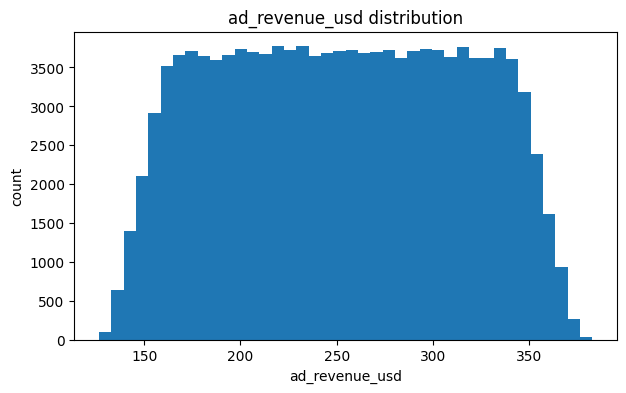

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Basic target distribution
plt.figure(figsize=(7,4))
plt.hist(df["ad_revenue_usd"].dropna(), bins=40)
plt.title("ad_revenue_usd distribution")
plt.xlabel("ad_revenue_usd")
plt.ylabel("count")
plt.show()

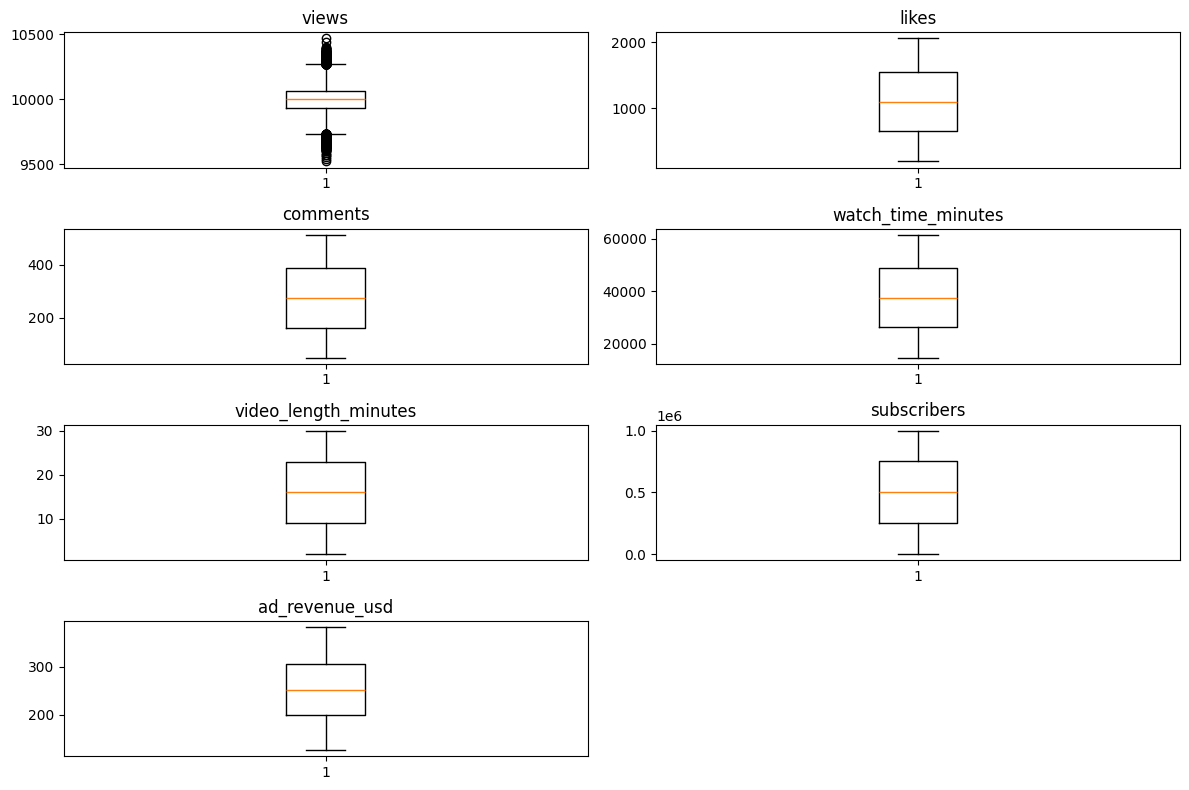

In [4]:
#Boxplots for key numeric features
numeric_cols = ["views", "likes", "comments", "watch_time_minutes", "video_length_minutes", "subscribers", "ad_revenue_usd"]
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4,2,i)
    plt.boxplot(df[col].dropna())
    plt.title(col)
plt.tight_layout()
plt.show()

In [5]:
# Category-wise average revenue (top categories)
cat_avg = df.groupby("category")["ad_revenue_usd"].mean().sort_values(ascending=False)
print("\nTop 10 categories by avg ad_revenue_usd:")
display(cat_avg.head(10))


Top 10 categories by avg ad_revenue_usd:


category
Gaming           253.507619
Tech             253.473340
Music            252.587527
Education        252.481643
Entertainment    252.445854
Lifestyle        251.860649
Name: ad_revenue_usd, dtype: float64

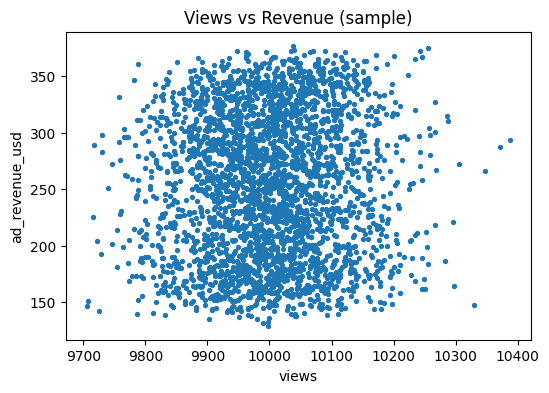

In [6]:
sample = df.sample(n=min(3000, len(df)), random_state=42)
plt.figure(figsize=(6,4))
plt.scatter(sample["views"], sample["ad_revenue_usd"], s=8)
plt.xlabel("views")
plt.ylabel("ad_revenue_usd")
plt.title("Views vs Revenue (sample)")
plt.show()

In [7]:
df = df.copy()
# Convert date -> upload_month/dayofweek if exists
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["upload_month"] = df["date"].dt.month.fillna(0).astype(int)
    df["upload_dayofweek"] = df["date"].dt.dayofweek.fillna(0).astype(int)
    df.drop(columns=["date"], inplace=True)

# Ensure numeric columns exist (create as NaN if missing so imputer later handles)
for c in ['views', 'likes', 'comments', 'watch_time_minutes', 'video_length_minutes', 'subscribers', 'ad_revenue_usd']:
    if c not in df.columns:
        df[c] = np.nan
    else:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop full-duplicate rows
df.drop_duplicates(inplace=True)
df.duplicated().sum()

        

np.int64(0)

In [8]:
#Feature engineering 
# clip negatives to 0
for c in ['views','likes','comments','watch_time_minutes','subscribers','video_length_minutes']:
    if c in df.columns:
        df[c] = df[c].clip(lower=0)

# log transforms (create columns; leave NaNs as-is)
for col in ['views','likes','comments','watch_time_minutes','subscribers']:
    df[f'log_{col}'] = np.log1p(df[col])

# engagement metrics (avoid division by zero; keep NaN if views is 0/NaN)
df['engagement_rate'] = (df['likes'].fillna(0) + df['comments'].fillna(0)) / df['views'].replace({0: np.nan})
df['watch_time_per_view'] = df['watch_time_minutes'].fillna(0) / df['views'].replace({0: np.nan})

# make sure upload_month/dayofweek exist
if 'upload_month' not in df.columns:
    df['upload_month'] = 0
if 'upload_dayofweek' not in df.columns:
    df['upload_dayofweek'] = 0


In [9]:
#  Choose features & target 
drop_cols = ["video_id", "views"]  # keep log_views instead of raw views (if present)
# Build candidate_features similar to your earlier approach
candidate_features = []
for c in ['video_length_minutes','views','likes','comments','watch_time_minutes','subscribers']:
    if c in df.columns:
        candidate_features.append(c)
for c in ['log_views','log_likes','log_comments','log_watch_time_minutes','engagement_rate','watch_time_per_view','upload_month','upload_dayofweek']:
    if c in df.columns:
        candidate_features.append(c)
# categorical columns
possible_cats = ['category', 'device', 'country']
categorical_features = [c for c in possible_cats if c in df.columns]
candidate_features += [c for c in categorical_features if c not in candidate_features]

print("Candidate features:", candidate_features)
print("Categorical features:", categorical_features)

# Drop rows with missing target
df = df.dropna(subset=['ad_revenue_usd'])
y = df['ad_revenue_usd'].astype(float)
X = df[candidate_features].copy()

Candidate features: ['video_length_minutes', 'views', 'likes', 'comments', 'watch_time_minutes', 'subscribers', 'log_views', 'log_likes', 'log_comments', 'log_watch_time_minutes', 'engagement_rate', 'watch_time_per_view', 'upload_month', 'upload_dayofweek', 'category', 'device', 'country']
Categorical features: ['category', 'device', 'country']


In [10]:
# --- 5) Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (96000, 17) Test shape: (24000, 17)


In [11]:
# --- 6) Robust selection of numeric & categorical features based on X dtypes ---
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
# Ensure categorical list only includes non-numeric columns present in X
categorical_features = [c for c in categorical_features if c in X.columns and not pd.api.types.is_numeric_dtype(X[c])]
# Also capture other non-numeric columns not listed in possible_cats
other_non_numeric = [c for c in X.columns if c not in numeric_features and c not in categorical_features]
categorical_features += other_non_numeric
# remove duplicates
categorical_features = list(dict.fromkeys(categorical_features))

print("Numeric features (count):", len(numeric_features))
print("Numeric preview:", numeric_features[:20])
print("Categorical features (count):", len(categorical_features))
print("Categorical preview:", categorical_features[:20])

Numeric features (count): 14
Numeric preview: ['video_length_minutes', 'views', 'likes', 'comments', 'watch_time_minutes', 'subscribers', 'log_views', 'log_likes', 'log_comments', 'log_watch_time_minutes', 'engagement_rate', 'watch_time_per_view', 'upload_month', 'upload_dayofweek']
Categorical features (count): 3
Categorical preview: ['category', 'device', 'country']


In [12]:
# --- 7) Build preprocessors ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),   # mean imputation as you requested
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),  # safe for object dtypes
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop", sparse_threshold=0)


In [13]:
# --- 8) Models to train ---
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}
if XGBOOST_AVAILABLE:
    models["XGBoost"] = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
else:
    print("XGBoost not available; install xgboost to include it (pip install xgboost)")

In [14]:
# --- 9) Train, evaluate, save best pipeline ---
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    print(f"\nTraining {name} ...")
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f"{name}: R2={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
    results.append({"name": name, "pipeline": pipe, "r2": r2, "rmse": rmse, "mae": mae})


Training LinearRegression ...


LinearRegression: R2=0.9526, RMSE=13.4822, MAE=3.1156

Training DecisionTree ...


DecisionTree: R2=0.8981, RMSE=19.7619, MAE=5.1278

Training RandomForest ...


RandomForest: R2=0.9502, RMSE=13.8121, MAE=3.4387

Training GradientBoosting ...


GradientBoosting: R2=0.9522, RMSE=13.5338, MAE=3.7074

Training XGBoost ...


XGBoost: R2=0.9463, RMSE=14.3505, MAE=3.8761


In [15]:
# Summary
results_df = pd.DataFrame([{"Model": r["name"], "R2": r["r2"], "RMSE": r["rmse"], "MAE": r["mae"]} for r in results])
results_df = results_df.sort_values(by="R2", ascending=False).reset_index(drop=True)
print("\nModel comparison:\n", results_df)

best = max(results, key=lambda x: x["r2"])
print("Best model:", best["name"], "R2:", best["r2"])


Model comparison:
               Model        R2       RMSE       MAE
0  LinearRegression  0.952559  13.482224  3.115578
1  GradientBoosting  0.952195  13.533792  3.707399
2      RandomForest  0.950209  13.812113  3.438724
3           XGBoost  0.946251  14.350530  3.876095
4      DecisionTree  0.898073  19.761850  5.127795
Best model: LinearRegression R2: 0.9525586504039976


In [16]:
# Save best pipeline and column list
joblib.dump(best["pipeline"], os.path.join(OUT_DIR, "LinearRegression.pkl"))
joblib.dump(candidate_features, os.path.join(OUT_DIR, "model_input_columns.pkl"))
results_df.to_csv(os.path.join(OUT_DIR, "model_scores.csv"), index=False)
X_test.head(20).to_csv(os.path.join(OUT_DIR, "X_test_sample.csv"), index=False)

print("LinearRegression", OUT_DIR)

LinearRegression ./model_artifacts


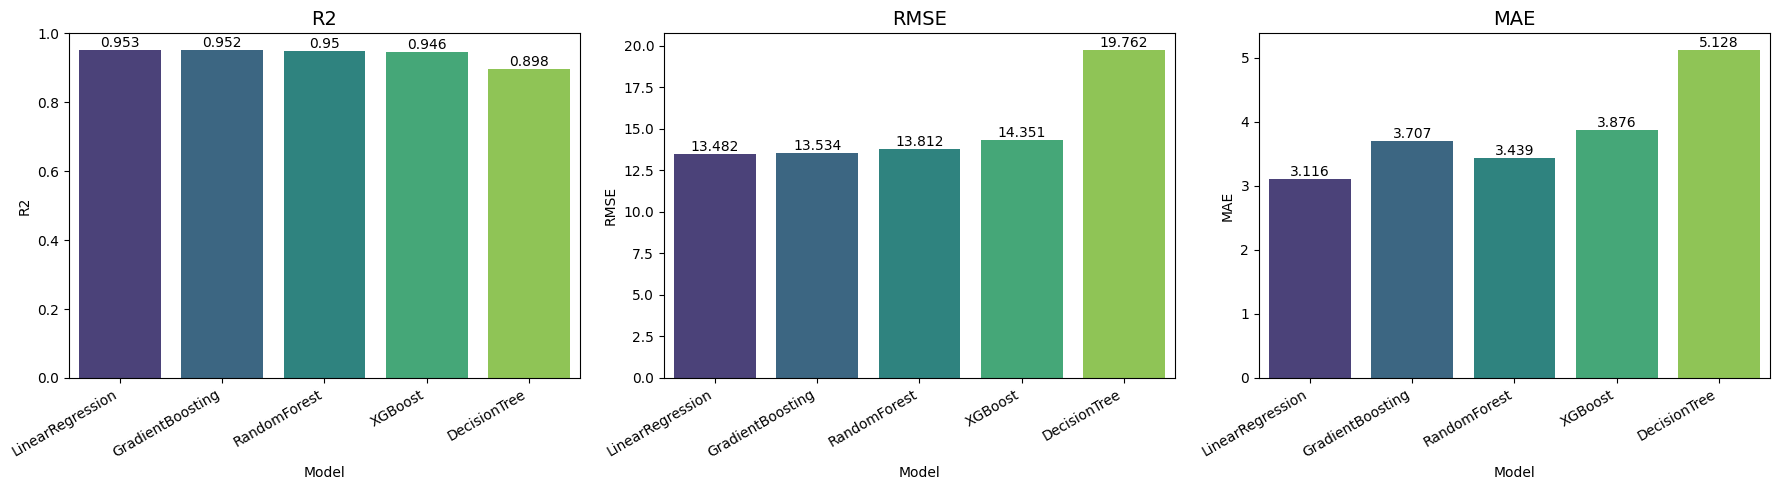

In [17]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set metrics for visualization
metrics = ['R2', 'RMSE', 'MAE']

# Set figure size
plt.figure(figsize=(18, 5))

# Loop through metrics and plot
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(data=results_df, x="Model", y=metric, palette="viridis")
    plt.title(metric, fontsize=14)
    plt.xticks(rotation=30, ha="right")
    # Add value labels on top of bars
    for idx, val in enumerate(results_df[metric]):
        plt.text(idx, val, round(val, 3), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
